In [11]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Define dataset path
data_path = "/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset"

# Define transformations (Resizing, Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [14]:
# Load the entire dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Define train-validation split ratio
train_size = int(0.8 * len(full_dataset))  # 80% training data
val_size = len(full_dataset) - train_size  # 20% validation data

# Split dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get number of classes
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

Number of classes: 31
Training samples: 6284, Validation samples: 1572


In [15]:
from torchvision.models import densenet121

# Load a pretrained DenseNet121 model
model = densenet121(pretrained=True)

# Modify the classifier layer
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []  # Store training loss per epoch
    val_losses = []  # Store validation loss per epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get predicted classes
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Compute Average Train Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Compute Average Validation Loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1: Train Loss: 0.9481, Train Acc: 71.90%
Epoch 1: Val Loss: 0.7027, Val Acc: 78.63%

Epoch 2: Train Loss: 0.3377, Train Acc: 90.17%
Epoch 2: Val Loss: 0.4633, Val Acc: 85.56%

Epoch 3: Train Loss: 0.2077, Train Acc: 93.73%
Epoch 3: Val Loss: 0.2705, Val Acc: 91.54%

Epoch 4: Train Loss: 0.1929, Train Acc: 94.56%
Epoch 4: Val Loss: 0.3193, Val Acc: 89.89%

Epoch 5: Train Loss: 0.1321, Train Acc: 95.91%
Epoch 5: Val Loss: 0.2144, Val Acc: 93.77%

Epoch 6: Train Loss: 0.0999, Train Acc: 97.02%
Epoch 6: Val Loss: 0.3344, Val Acc: 90.20%

Epoch 7: Train Loss: 0.1031, Train Acc: 96.82%
Epoch 7: Val Loss: 0.2156, Val Acc: 93.83%

Epoch 8: Train Loss: 0.0695, Train Acc: 97.88%
Epoch 8: Val Loss: 0.1694, Val Acc: 94.21%

Epoch 9: Train Loss: 0.0795, Train Acc: 97.55%
Epoch 9: Val Loss: 0.3288, Val Acc: 90.14%

Epoch 10: Train Loss: 0.1145, Train Acc: 96.29%
Epoch 10: Val Loss: 0.2696, Val Acc: 91.92%

Epoch 11: Train Loss: 0.0641, Train Acc: 97.98%
Epoch 11: Val Loss: 0.2072, Val Acc: 94.

In [19]:
torch.save(model.state_dict(), "arabic_sign_language_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [20]:
# Load the model
model.load_state_dict(torch.load("arabic_sign_language_model.pth"))
model.eval()

<ipython-input-20-4de680b6b992>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("arabic_sign_language_model.pth"))


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

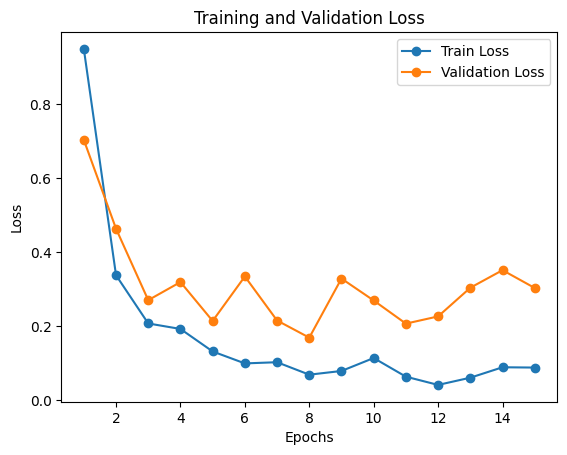

In [21]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Generate classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Validation Accuracy: 90.71%

Classification Report:
               precision    recall  f1-score   support

         Ain       0.96      0.98      0.97        50
          Al       0.98      1.00      0.99        43
        Alef       0.93      0.98      0.95        54
         Beh       0.98      0.88      0.93        50
         Dad       1.00      0.95      0.97        58
         Dal       0.97      0.77      0.86        47
         Feh       0.78      0.92      0.84        62
       Ghain       0.98      0.92      0.95        62
         Hah       0.85      0.94      0.90        50
         Heh       0.94      0.82      0.87        38
        Jeem       0.91      0.89      0.90        44
         Kaf       0.98      0.93      0.95        54
        Khah       1.00      0.88      0.94        43
         Laa       0.88      0.98      0.93        54
         Lam       0.94      1.00      0.97        51
        Meem       0.93      0.97      0.95        59
        Noon       0.88     

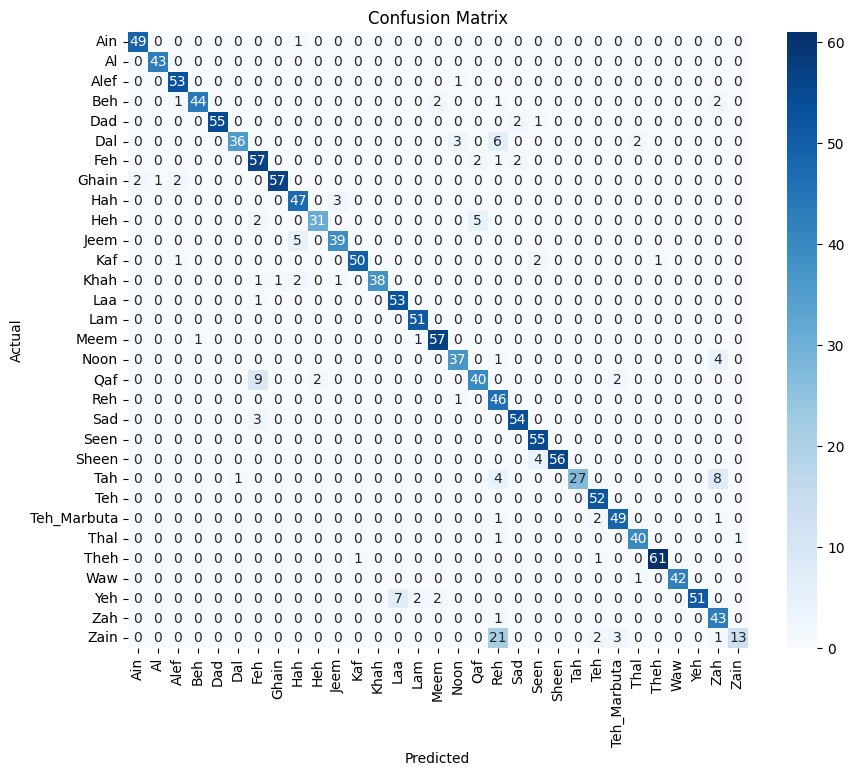

In [23]:
evaluate_model(model, val_loader, train_dataset.dataset.classes)